In [1]:
#!pip install pycuda

In [2]:
from time import time
import warnings
warnings.filterwarnings("ignore")

### Cuda Map and Reduce Kernels

In [3]:
%%writefile kmeans_map_reduce_steps.cu

#include <cuda_runtime.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>


extern "C" __global__ void kmeans_map_step(float * data_mtx_dn, int dim_x, int dim_y, \
                                          int n_clusters, \
                                          float * centers_mtx_dc, \
                                          float * output_labels_cn, \
                                          float * output_distances_cn \
                                          )
{
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    //printf("Hello world from tid %d, thread %d, in block %d!\n", tid, threadIdx.x, blockIdx.x);
	  __syncthreads();

    //assign this thread tid to the ith column of the data_mtx
    // for all columns of the data mtx do this:
    if ( tid < dim_x ) //we don't care about threads with larger tid
    {   
        int col = tid;
        float current_best_val=-100.0 ;
        int current_label =0;  

        for (int k = 0; k< n_clusters; k++)
        { 
          float sq_dist_k=0 ;
          for (int row = 0; row< dim_y; row++)
          {
            float val_data_mtx = data_mtx_dn[col+row*dim_x];
            float val_centers_mtx = centers_mtx_dc[k+row*n_clusters];
            float diff = val_data_mtx-val_centers_mtx;
            sq_dist_k=sq_dist_k+diff*diff ;
          }
          
          output_distances_cn[col+k*dim_x]=sq_dist_k;   

          if (current_best_val< 0)
          {
            current_best_val=sq_dist_k;
            current_label = k;
          }       
          else if (current_best_val>sq_dist_k)
          {
              current_label=k;
              current_best_val=sq_dist_k;
          } 
        }  
        output_labels_cn[tid+current_label*dim_x] = 1;
    }
    
    return;
}

const int threadsPerBlock = 1024; //must be a power of 2!

extern "C" __global__ void dot_prod_ker(int dim, float *a, float *b, float *c )
{
  __shared__ float cache[threadsPerBlock];
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    int cacheIndex = threadIdx.x;

    float   temp = 0;
    while (tid < dim) {
        temp += a[tid] * b[tid];
        tid += blockDim.x * gridDim.x;
    }
    
    // set the cache values
    cache[cacheIndex] = temp;
    
    // synchronize threads in this block
    __syncthreads();

    // Reduction starts here!
    // We have blockDim.x * gridDim.x num of threads, 
    // each containing a partial sum
    
    // for reductions, threadsPerBlock must be a power of 2
    // because of the following code
    int i = blockDim.x/2; //e.g 256/2
    // Let us recursively sum the threads in the blocks
    // The lower half gets the increade by the values from the upper half
    while (i != 0) {
        if (cacheIndex < i)
            cache[cacheIndex] += cache[cacheIndex + i];
        __syncthreads();
        i /= 2;
    }

    if (cacheIndex == 0)
        c[blockIdx.x] = cache[0];
}


Overwriting kmeans_map_reduce_steps.cu


In [4]:
!nvcc -ptx -o kmeans_map_reduce_steps.ptx kmeans_map_reduce_steps.cu

In [5]:
def plot_data(Xs_,C):
  n=len(Xs_)
  Xs=Xs_[:min(1000,n)] #to avoid plotting too many points
  fig = plt.figure()

  ax0 = fig.add_subplot(111)
  ax0.scatter([point[0] for point in Xs], [point[1] for point in Xs])
  ax0.set_title('Dataset')

  plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=300, c='r')

### Kmeans EM

In [6]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from time import time
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

import numpy as np


In [7]:
n_samples=50000 #n
n_features =2 #d

n_clusters=np.int32(3) #c
dim_x= np.int32(n_samples)
dim_y=np.int32(n_features)


# Creating a n_features=2 Dim dataset with centers=3 clusters
np.random.seed(150)

Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)

data_mtx_dn=np.float32(Xs.T.copy())
#centers_mtx_dc = data_mtx_dn[:,:n_clusters]
centers_mtx_dc = np.float32(np.random.randn(n_features,n_clusters))
C0_dc=centers_mtx_dc

print(f' data mtx shape: {data_mtx_dn.shape}')
print(f' centers_mtx shape: {centers_mtx_dc.shape}')


 data mtx shape: (2, 50000)
 centers_mtx shape: (2, 3)


In [8]:
print(C0_dc)

[[-0.12963675 -1.3849705  -0.13330725]
 [ 0.20627569 -2.3130724   0.85683733]]


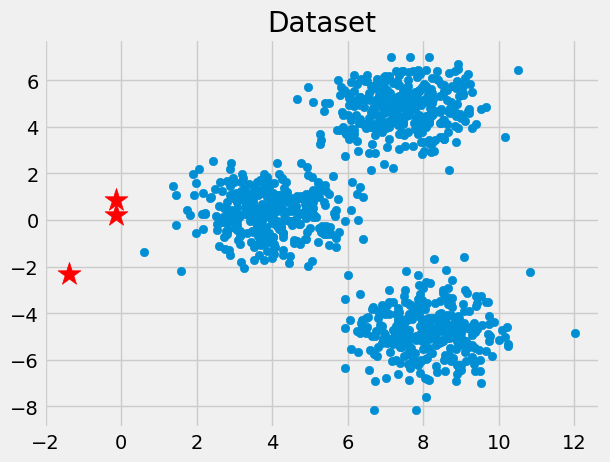

In [9]:
if n_features==2:
  plot_data(Xs,centers_mtx_dc.T)

In [10]:
data_mtx_dn_gpu=gpuarray.to_gpu(data_mtx_dn)
centers_mtx_dc_gpu=gpuarray.to_gpu(centers_mtx_dc)

In [11]:
my_mod = pycuda.driver.module_from_file('./kmeans_map_reduce_steps.ptx')
kmeans_map_step_ker = my_mod.get_function('kmeans_map_step')
dot_prod_ker=my_mod.get_function('dot_prod_ker')

In [12]:
blocksize = 100
gridsize = int(np.ceil(dim_x*dim_y / blocksize))

print(f'block size: {blocksize}')
print(f'grid size: {gridsize}')


block size: 100
grid size: 1000


In [13]:
if 0: #DEBUG E-STEP

  output_distances_cn=np.float32(np.zeros([n_clusters,n_samples]))
  output_labels_cn=np.float32(np.zeros([n_clusters,n_samples]))
  output_distances_cn_gpu = gpuarray.to_gpu(output_distances_cn)
  output_labels_cn_gpu = gpuarray.to_gpu(output_labels_cn)

  t1=time()
  kmeans_map_step_ker(data_mtx_dn_gpu, np.int32(dim_x), np.int32(dim_y), np.int32(n_clusters), 
                      centers_mtx_dc_gpu, 
                      output_labels_cn_gpu, 
                      output_distances_cn_gpu, grid=(gridsize, 1, 1), block=(blocksize,1,1))
  drv.Context.synchronize()
  t1=time()-t1
  print(f'E-step Elapsed time: {t1}')

  #print(output_distances_cn_gpu.T)
  #print(output_labels_cn_gpu.T)

***EM Iteration***

In [14]:
dim=n_samples

threadsPerBlock = 1024; #this have to be a power of 2
blocksPerGrid=32

print(f'num of blocks: {blocksPerGrid}')
print(f'num of threads in each block: {threadsPerBlock}')
print(f'total number of threads in the grid: {blocksPerGrid*threadsPerBlock}')
print(f'dim of vectors: {dim}')

ones_n=np.float32(np.ones(n_samples))
ones_n_gpu=gpuarray.to_gpu(ones_n)


num of blocks: 32
num of threads in each block: 1024
total number of threads in the grid: 32768
dim of vectors: 50000


In [15]:

EM_iternum=10
t=time()

for EM_iters in np.arange(EM_iternum):
  print(f'*** {EM_iters} ***')
  t1=time()

  output_labels_cn=np.float32(np.zeros([n_clusters,n_samples]))
  output_labels_cn_gpu = gpuarray.to_gpu(output_labels_cn)

  output_distances_cn=np.float32(np.zeros([n_clusters,n_samples])) 
  output_distances_cn_gpu = gpuarray.to_gpu(output_distances_cn)

  kmeans_map_step_ker(data_mtx_dn_gpu, np.int32(dim_x), np.int32(dim_y), np.int32(n_clusters), 
                      centers_mtx_dc_gpu, 
                      output_labels_cn_gpu, 
                      output_distances_cn_gpu, grid=(gridsize, 1, 1), block=(blocksize,1,1))
  drv.Context.synchronize()
  t1=time()-t1
  print(f'E-step Elapsed time: {t1}')

  # M-Step Counts
  t1=time()

  vecc=np.float32(np.zeros(blocksPerGrid))
  vecc_gpu=gpuarray.to_gpu(vecc)

  counts = np.zeros(n_clusters)
  for iter in np.arange(n_clusters):
    veca_gpu=output_labels_cn_gpu[iter,:]
    vecb_gpu=ones_n_gpu
    dot_prod_ker(np.int32(dim), veca_gpu,vecb_gpu,vecc_gpu,grid=(blocksPerGrid, 1, 1), block=(threadsPerBlock,1,1))
    counts[iter]=np.sum(vecc_gpu.get())

  drv.Context.synchronize()
  t1=time()-t1
  print(f'M-step Counts Elapsed time: {t1}')
  #print(counts)

  #M_step vectors
  t1=time()
  sum_vectors = np.zeros([n_features,n_clusters])
  for d in np.arange(n_features):
    for c in np.arange(n_clusters):
      veca_gpu= data_mtx_dn_gpu[d,:]
      vecb_gpu=output_labels_cn_gpu[c,:]
      dot_prod_ker(np.int32(dim), veca_gpu,vecb_gpu,vecc_gpu,grid=(blocksPerGrid, 1, 1), block=(threadsPerBlock,1,1))
      tmp_val=np.sum(vecc_gpu.get())
      sum_vectors[d,c]= tmp_val
  drv.Context.synchronize()
  t1=time()-t1
  
  print(f'M-step Vectors Elapsed time: {t1}')
  centers_mtx_dc = np.float32(sum_vectors/counts)
  #print(centers_mtx_dc)
  centers_mtx_dc_gpu= gpuarray.to_gpu(centers_mtx_dc)

tGPU=time()-t
print(f'GPU Elapsed time: {tGPU}')

*** 0 ***
E-step Elapsed time: 0.004015922546386719
M-step Counts Elapsed time: 0.0014345645904541016
M-step Vectors Elapsed time: 0.001287221908569336
*** 1 ***
E-step Elapsed time: 0.0018665790557861328
M-step Counts Elapsed time: 0.0009663105010986328
M-step Vectors Elapsed time: 0.0011544227600097656
*** 2 ***
E-step Elapsed time: 0.004716396331787109
M-step Counts Elapsed time: 0.0011134147644042969
M-step Vectors Elapsed time: 0.001249551773071289
*** 3 ***
E-step Elapsed time: 0.0011925697326660156
M-step Counts Elapsed time: 0.0009391307830810547
M-step Vectors Elapsed time: 0.0011293888092041016
*** 4 ***
E-step Elapsed time: 0.0012793540954589844
M-step Counts Elapsed time: 0.0009737014770507812
M-step Vectors Elapsed time: 0.0011506080627441406
*** 5 ***
E-step Elapsed time: 0.0014414787292480469
M-step Counts Elapsed time: 0.000926971435546875
M-step Vectors Elapsed time: 0.0011212825775146484
*** 6 ***
E-step Elapsed time: 0.0015869140625
M-step Counts Elapsed time: 0.0009

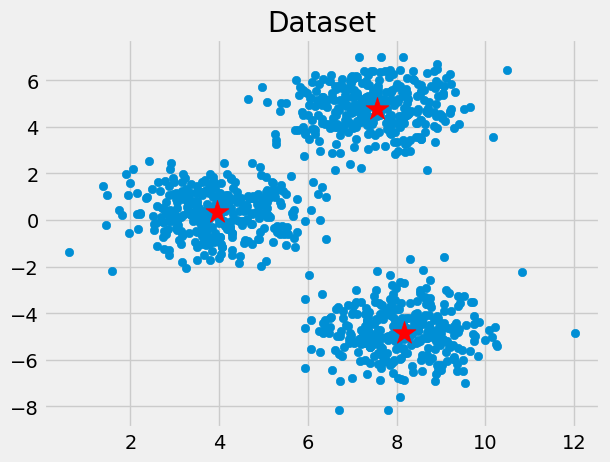

In [16]:
if n_features ==2:
  plot_data(Xs,centers_mtx_dc.T)

In [22]:
print(centers_mtx_dc)

[[ 3.9558465   8.16736     7.5580096 ]
 [ 0.33891115 -4.8317385   4.7721224 ]]


### Verification

In [17]:
C0_dc

array([[-0.12963675, -1.3849705 , -0.13330725],
       [ 0.20627569, -2.3130724 ,  0.85683733]], dtype=float32)

In [18]:
def EMstep(data_mtx, C0):
  t1=time()

  n_clusters= C0.shape[1]
  n_samples= data_mtx.shape[1]
  n_dim = data_mtx.shape[0]
  centers_mtx=C0
  output_mtx_cpu=np.float32(np.zeros([n_clusters,n_samples]))
  for i in np.arange(n_samples):
    for k in np.arange(n_clusters):
      val=data_mtx[:,i]-centers_mtx[:,k]
      output_mtx_cpu[k,i]=np.inner(val,val)
  #print(output_mtx_cpu.T[:10,:])

  labels=np.argmin(output_mtx_cpu,axis=0)
  t1=time()-t1
  print(f'E-step Elapsed time: {t1}')

  #print(labels)

  t1=time()-t1
 
  tmp1=data_mtx.T
  tmp1

  tmp2=labels.T
  tmp2

  sum_vecs=[]
  counts=np.zeros(n_clusters)
  for iter in np.arange(n_clusters):
    inds = (tmp2==iter)
    inds
    counts[iter]=np.sum(inds)
    sum_vecs.append(np.sum(tmp1[inds,:],axis=0))
  
  #print(counts)
  #print(np.array(sum_vecs).T)
  C_new=np.array(sum_vecs).T/counts
  #print(f'C_new:\n {C_new}')
  t1=time()-t1
  print(f'M-step Elapsed time: {t1}')
  return C_new


In [19]:
t=time()
Ctmp = C0_dc
for iters in np.arange(EM_iternum): 
  Ctmp=EMstep(data_mtx_dn, Ctmp)

tCPU=time()-t
print(f'CPU Elapsed time: {tCPU}')
print(Ctmp)

E-step Elapsed time: 0.9338164329528809
M-step Elapsed time: 0.9416773319244385
E-step Elapsed time: 1.4210569858551025
M-step Elapsed time: 1.4259519577026367
E-step Elapsed time: 1.6843135356903076
M-step Elapsed time: 1.6892523765563965
E-step Elapsed time: 1.6068308353424072
M-step Elapsed time: 1.6270627975463867
E-step Elapsed time: 1.9810206890106201
M-step Elapsed time: 1.9850621223449707
E-step Elapsed time: 2.411224842071533
M-step Elapsed time: 2.4191133975982666
E-step Elapsed time: 1.3710713386535645
M-step Elapsed time: 1.3746137619018555
E-step Elapsed time: 0.6148545742034912
M-step Elapsed time: 0.6183581352233887
E-step Elapsed time: 0.6258876323699951
M-step Elapsed time: 0.6294159889221191
E-step Elapsed time: 0.9969320297241211
M-step Elapsed time: 1.0005030632019043
CPU Elapsed time: 13.717145442962646
[[ 3.9558545   8.16734817  7.55800645]
 [ 0.33891091 -4.83172659  4.77213635]]


In [20]:
print(f'*** GPU is {tCPU/tGPU} times faster than CPU ***')


*** GPU is 281.324124374728 times faster than CPU ***


[[ 3.9558545   8.16734817  7.55800645]
 [ 0.33891091 -4.83172659  4.77213635]]


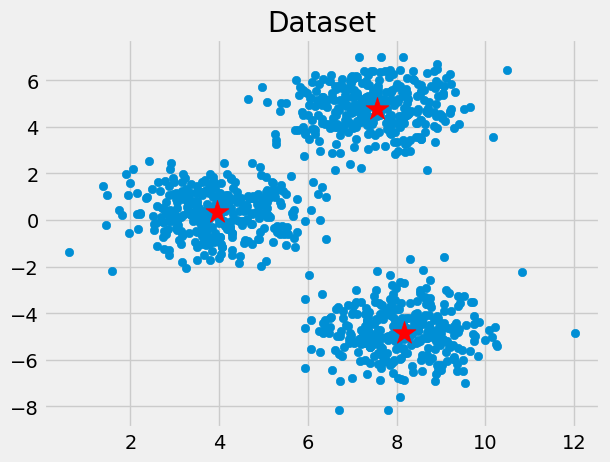

In [21]:
centers_mtx=Ctmp
print(centers_mtx)
if n_features ==2:
  plot_data(Xs,centers_mtx.T)